<a href="https://colab.research.google.com/github/Pretty-Witty-Bot/ReinforcementLearningModels/blob/main/DQN_Modified_Mountain_Car_Env_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Install the necessary Lbraries and Modules.
"""

!pip install gym
!pip install gym[classic_control]
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
"""
Import Libraries and Modules.
"""

import numpy as np
import math
import gym
import matplotlib.pyplot as plt 
from gym.wrappers import RecordVideo
import pygame
from copy import deepcopy
from gym.spaces import Discrete, Dict, Box
from gym.envs.classic_control import MountainCarEnv
from gym.utils.renderer import Renderer
import torch 
import torch.nn as nn
import torch.nn.functional as F
import random 
from collections import namedtuple, deque 
import torch.optim as optim

In [3]:
"""
Initialize the environment.
"""

class ModifiedMountainCarEnv(MountainCarEnv):
    def __init__(self, config=None):
        super().__init__('ModifiedMountainCarEnv')
        self.render_mode = "rgb_array"

        self.renderer = Renderer(self.render_mode, self._render)

    def step(self, action: int):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"

        position, velocity = self.state
        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        )

        state = np.array(self.state, dtype=np.float32)
        if terminated:
          pre_reward = 2000
        else:
          pre_reward = -1
        reward = pre_reward + abs(state[1])
        self.state = (position, velocity)
        self.renderer.render_step()
        return state, reward, terminated, False, {}

env = ModifiedMountainCarEnv()

In [4]:
"""
Figure out the dimensions that we are working with.
"""

observation_space = env.observation_space
action_space = env.action_space

print("The observation space: {}".format(observation_space))
print("The action space: {}".format(action_space))

The observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space: Discrete(3)


In [5]:
"""
QNetwork Class. Code derived from: https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda
"""

class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size = 2, action_size = 3, seed = 0, fc1_unit=64,
                 fc2_unit = 48, fc3_unit = 24):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,fc3_unit)
        self.fc4 = nn.Linear(fc3_unit,action_size)
        
    def forward(self,x):
        """
        Build a network that maps state -> action values.
        """
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [6]:
"""
Agent Class. Code derived from: https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda
"""

BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.9999            # discount factor
TAU = 1e-4              # for soft update of target parameters
LR = 1e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns form environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):

        self.memory.add(state, action, reward, next_step, done)

        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
    def act(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_state, dones = experiences
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
    
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_state).detach().max(1)[0].unsqueeze(1)

        labels = rewards + (gamma* labels_next*(1-dones))
        
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [12]:
"""
Run the DQN Training Algorithm.
"""

agent = Agent(state_size=observation_space.shape[0],action_size=action_space.n,seed=0)

def dqn(n_episodes= 400, max_t = 2000, eps_start=0.3):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    """
    episode_scores = []
    state = env.reset()
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        scores = []
        final_step = 0
        for t in range(max_t + 1):
            score = 0
            action = agent.act(state,eps)
            next_state,reward,done,truncated,infos = env.step(action)

            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            scores.append(score)
            if done:
                final_step = t
                break
            final_step = t
        print('\rEpisode {}\tAverage Score {:.5f}\tFinal Step {}'.format(i_episode,np.mean(scores), final_step))
        episode_scores.append(np.mean(scores))
        state = env.reset()
    return scores, episode_scores, agent

scores, episode_scores, agent = dqn()

Episode 1	Average Score -0.99182	Final Step 2000
Episode 2	Average Score -0.98775	Final Step 2000
Episode 3	Average Score -0.99520	Final Step 2000
Episode 4	Average Score -0.99764	Final Step 2000
Episode 5	Average Score -0.99810	Final Step 2000
Episode 6	Average Score -0.99788	Final Step 2000
Episode 7	Average Score -0.99783	Final Step 2000
Episode 8	Average Score -0.99754	Final Step 2000
Episode 9	Average Score -0.99664	Final Step 2000
Episode 10	Average Score -0.99692	Final Step 2000
Episode 11	Average Score -0.99612	Final Step 2000
Episode 12	Average Score -0.99607	Final Step 2000
Episode 13	Average Score -0.99527	Final Step 2000
Episode 14	Average Score -0.99380	Final Step 2000
Episode 15	Average Score -0.99359	Final Step 2000
Episode 16	Average Score -0.99208	Final Step 2000
Episode 17	Average Score -0.99026	Final Step 2000
Episode 18	Average Score -0.99218	Final Step 2000
Episode 19	Average Score -0.98988	Final Step 2000
Episode 20	Average Score -0.99097	Final Step 2000
Episode 2

In [24]:
"""
Record the Agent picking actions (set eps = 1 to make the Agent pick what it
thinks is the best action).
"""

video_recorder = RecordVideo(env, './custom_env', video_length = 0)

state = video_recorder.reset()


STEPS = 2000
for step in range(STEPS + 1):  

  action = agent.act(state, eps = 0.3)

  next_state, reward, done, info = video_recorder.step(action)
  state = next_state
  video_recorder.render()

  if done:
    print(f"Final Step: {step}")
    state = video_recorder.reset()
    break

  final_step = step

print(f"Final Step: {final_step}")
video_recorder.close_video_recorder()
env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/custom_env folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


Final Step: 1605
Final Step: 1604


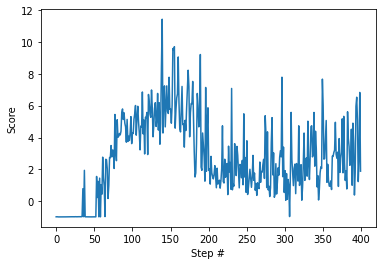

In [25]:
"""
Plotting the scores.
"""

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episode_scores)
plt.ylabel('Score')
plt.xlabel('Step #')
plt.show()